In [1]:
conda activate TFgpu


Note: you may need to restart the kernel to use updated packages.


![Image Description](Image/Twitter1.png)

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import FunctionTransformer
import re
import matplotlib.pyplot as plt

In [3]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text_list, tokenizer, stopwords_list, remove_words):
    '''
    Takes in a list of strings, a tokenizer, a list of stopwords, and a list of words to remove.
    Returns a list of lowercased, tokenized, stopwords-removed, and lemmatized words.
    '''
    # lowercase
    lower = [str(text).lower() for text in text_list]

    # tokenize
    tokenized = [tokenizer.tokenize(tweet) for tweet in lower]

    # stopwords and special characters
    no_stops = []
    for item in tokenized:
        temp = []
        for token in item:
            if token not in stopwords_list and token not in remove_words:
                # Remove special characters
                token = re.sub(r'\W+', '', token)
                temp.append(token)
        no_stops.append(temp)

    # preparation for lemmatization
    tags = [pos_tag(tokens) for tokens in no_stops]

    better_tags = []
    for item in tags:
        temp1 = []
        for word in item:
            temp1.append((word[0], get_wordnet_pos(word[1])))
        better_tags.append(temp1)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    lem = []
    for item in better_tags:
        temp2 = []
        for word in item:
            temp2.append(lemmatizer.lemmatize(word[0], word[1]))
        lem.append(temp2)

    preprocessed = [' '.join(i) for i in lem]

    return preprocessed

In [4]:
# Read the dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

# Remove tweets with unknown sentiment
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

# Remove 'No emotion toward brand or product' category
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != 'No emotion toward brand or product']

# Load and preprocess the data
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create the tokenizer and stopwords list
tokenizer = TweetTokenizer()
stopwords_list = stopwords.words('english')

# Define the words to remove
remove_words = ['rt', 'mention', '2', 'iphone', 'sxswi', '2åê', '522', 522, '32', '0134']

In [6]:
# Create the pipeline for logistic regression
lr_pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Create the pipeline for the dummy model
dummy_pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
    ('tfidf', TfidfVectorizer()),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

# Define the hyperparameters to tune for logistic regression
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'classifier__C': [0.1, 1.0, 10.0]  # inverse of regularization strength
}

In [7]:
# Perform hyperparameter tuning using GridSearchCV for logistic regression
grid_search_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Get the best hyperparameters and model from GridSearchCV for logistic regression
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_


In [8]:
# Train the logistic regression model with the best hyperparameters
best_model_lr.fit(X_train, y_train)

# Train the dummy model
dummy_pipeline.fit(X_train, y_train)

# Make predictions using the logistic regression model
y_pred_lr = best_model_lr.predict(X_test)

# Make predictions using the dummy model
y_pred_dummy = dummy_pipeline.predict(X_test)

# Calculate evaluation metrics for the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)

# Calculate evaluation metrics for the dummy model
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
recall_dummy = recall_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
f1_dummy = f1_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)

In [9]:
# Print the best hyperparameters
print('Best Hyperparameters:')
for param, value in best_params_lr.items():
    print(f'{param}: {value}')
print('')

Best Hyperparameters:
classifier__C: 10.0
tfidf__ngram_range: (1, 2)



In [10]:
# Print the evaluation metrics for the logistic regression model
print('Logistic Regression Model:')
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1-score: {f1_lr}')
print('')

# Print the evaluation metrics for the dummy model
print('Dummy Classifier:')
print(f'Accuracy: {accuracy_dummy}')
print(f'Precision: {precision_dummy}')
print(f'Recall: {recall_dummy}')
print(f'F1-score: {f1_dummy}')

Logistic Regression Model:
Accuracy: 0.8774647887323944
Precision: 0.8687812929946244
Recall: 0.8774647887323944
F1-score: 0.8555468276811696

Dummy Classifier:
Accuracy: 0.8380281690140845
Precision: 0.8642630430470144
Recall: 0.8380281690140845
F1-score: 0.7641789433921538


In [11]:
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.dummy import DummyClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.model_selection import train_test_split, GridSearchCV
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk import pos_tag
# from nltk.corpus import wordnet
# from nltk.tokenize import TweetTokenizer
# from sklearn.preprocessing import FunctionTransformer
# import re
# import matplotlib.pyplot as plt

# def get_wordnet_pos(treebank_tag):
#     '''
#     Translate nltk POS to wordnet tags
#     '''
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN

# def clean_text(text_list, tokenizer, stopwords_list, remove_words):
#     '''
#     Takes in a list of strings, a tokenizer, a list of stopwords, and a list of words to remove.
#     Returns a list of lowercased, tokenized, stopwords-removed, and lemmatized words.
#     '''
#     # lowercase
#     lower = [str(text).lower() for text in text_list]

#     # tokenize
#     tokenized = [tokenizer.tokenize(tweet) for tweet in lower]

#     # stopwords and special characters
#     no_stops = []
#     for item in tokenized:
#         temp = []
#         for token in item:
#             if token not in stopwords_list and token not in remove_words:
#                 # Remove special characters
#                 token = re.sub(r'\W+', '', token)
#                 temp.append(token)
#         no_stops.append(temp)

#     # preparation for lemmatization
#     tags = [pos_tag(tokens) for tokens in no_stops]

#     better_tags = []
#     for item in tags:
#         temp1 = []
#         for word in item:
#             temp1.append((word[0], get_wordnet_pos(word[1])))
#         better_tags.append(temp1)

#     # Lemmatization
#     lemmatizer = WordNetLemmatizer()

#     lem = []
#     for item in better_tags:
#         temp2 = []
#         for word in item:
#             temp2.append(lemmatizer.lemmatize(word[0], word[1]))
#         lem.append(temp2)

#     preprocessed = [' '.join(i) for i in lem]

#     return preprocessed

# # Read the dataset
# df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

# # Remove tweets with unknown sentiment
# df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

# # Remove 'No emotion toward brand or product' category
# df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != 'No emotion toward brand or product']

# # Load and preprocess the data
# X = df['tweet_text']
# y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create the tokenizer and stopwords list
# tokenizer = TweetTokenizer()
# stopwords_list = stopwords.words('english')

# # Define the words to remove
# remove_words = ['rt', 'mention', '2', 'iphone', 'sxswi', '2åê', '522', 522, '32', '0134']

# # Create the pipeline for logistic regression
# lr_pipeline = Pipeline([
#     ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
#     ('tfidf', TfidfVectorizer()),
#     ('classifier', LogisticRegression(max_iter=1000))
# ])

# # Create the pipeline for the dummy model
# dummy_pipeline = Pipeline([
#     ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
#     ('tfidf', TfidfVectorizer()),
#     ('classifier', DummyClassifier(strategy='most_frequent'))
# ])

# # Define the hyperparameters to tune for logistic regression
# param_grid = {
#     'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
#     'classifier__C': [0.1, 1.0, 10.0]  # inverse of regularization strength
# }

# # Perform hyperparameter tuning using GridSearchCV for logistic regression
# grid_search_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='accuracy')
# grid_search_lr.fit(X_train, y_train)

# # Get the best hyperparameters and model from GridSearchCV for logistic regression
# best_params_lr = grid_search_lr.best_params_
# best_model_lr = grid_search_lr.best_estimator_

# # Train the logistic regression model with the best hyperparameters
# best_model_lr.fit(X_train, y_train)

# # Train the dummy model
# dummy_pipeline.fit(X_train, y_train)

# # Make predictions using the logistic regression model
# y_pred_lr = best_model_lr.predict(X_test)

# # Make predictions using the dummy model
# y_pred_dummy = dummy_pipeline.predict(X_test)

# # Calculate evaluation metrics for the logistic regression model
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
# precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)
# recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)
# f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)

# # Calculate evaluation metrics for the dummy model
# accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
# precision_dummy = precision_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
# recall_dummy = recall_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
# f1_dummy = f1_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)

# # Print the evaluation metrics for the logistic regression model
# print('Logistic Regression Model:')
# print(f'Accuracy: {accuracy_lr}')
# print(f'Precision: {precision_lr}')
# print(f'Recall: {recall_lr}')
# print(f'F1-score: {f1_lr}')
# print('')

# # Print the evaluation metrics for the dummy model
# print('Dummy Classifier:')
# print(f'Accuracy: {accuracy_dummy}')
# print(f'Precision: {precision_dummy}')
# print(f'Recall: {recall_dummy}')
# print(f'F1-score: {f1_dummy}')


In [12]:
# Logistic Regression Model:
# Accuracy: 0.8774647887323944
# Precision: 0.8687812929946244
# Recall: 0.8774647887323944
# F1-score: 0.8555468276811696

# Dummy Classifier:
# Accuracy: 0.8380281690140845
# Precision: 0.8642630430470144
# Recall: 0.8380281690140845
# F1-score: 0.7641789433921538

In [13]:
# Get the class labels
class_labels = best_model_lr.named_steps['classifier'].classes_

# Print the class labels
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

Class 0: Negative emotion
Class 1: Positive emotion


In [14]:
# Get the class labels
class_labels = best_model_lr.named_steps['classifier'].classes_

# Print the class labels
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

# Perform feature analysis for logistic regression
if 'tfidf' in best_model_lr.named_steps:
    tfidf_vec = best_model_lr.named_steps['tfidf']
    feature_names = tfidf_vec.get_feature_names_out()

    # Get the coefficients for the positive class
    coefficients = best_model_lr.named_steps['classifier'].coef_[0]

    # Sort the feature names and coefficients
    sorted_indices = coefficients.argsort()
    top_features = [feature_names[idx] for idx in sorted_indices[:10]]
    bottom_features = [feature_names[idx] for idx in sorted_indices[-10:]]

    # Print the top and bottom features
    print('Negative emotion:')
    print(top_features)
    print('Positive emotion:')
    print(bottom_features)
    

else:
    print('Feature analysis is not available for the chosen model.')

Class 0: Negative emotion
Class 1: Positive emotion
Negative emotion:
['fail', 'suck', 'hate', 'long', 'battery', 'headache', 'design headache', 'news apps', 'enough', 'ipad news']
Positive emotion:
['new', 'fun', 'party', 'mention', 'cool', 'ipad', 'great', 'free', 'win', 'link']


Class 0: Negative emotion
Class 1: Positive emotion
Negative emotion:
['fail', 'suck', 'hate', 'long', 'battery', 'headache', 'design headache', 'news apps', 'enough', 'ipad news']
Positive emotion:
['new', 'fun', 'party', 'mention', 'cool', 'ipad', 'great', 'free', 'win', 'link']


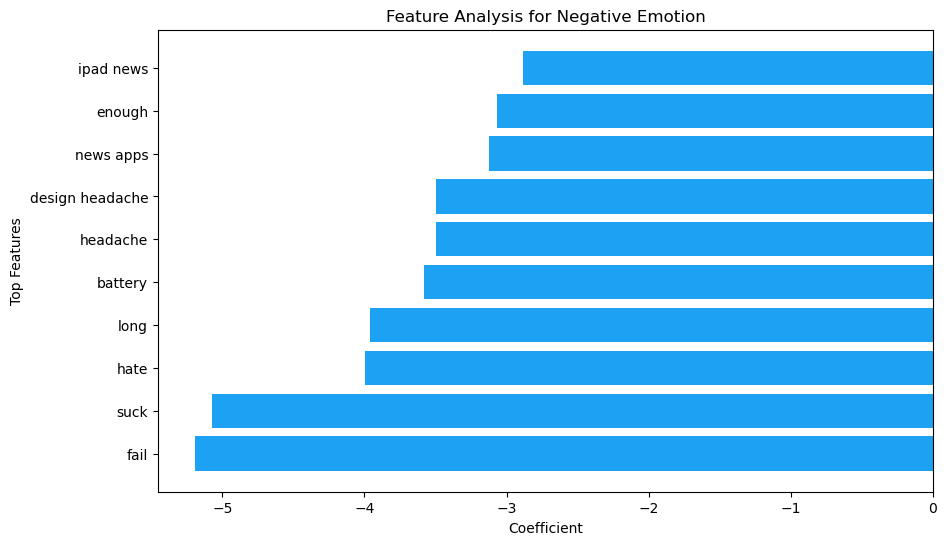

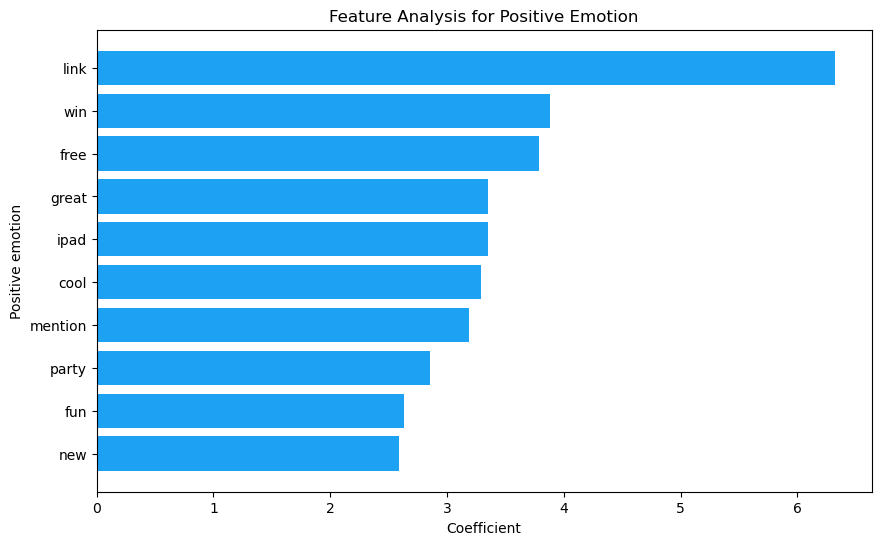

In [15]:
import matplotlib.pyplot as plt

# Get the class labels
class_labels = best_model_lr.named_steps['classifier'].classes_

# Print the class labels
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

# Perform feature analysis for logistic regression
if 'tfidf' in best_model_lr.named_steps:
    tfidf_vec = best_model_lr.named_steps['tfidf']
    feature_names = tfidf_vec.get_feature_names_out()

    # Get the coefficients for the positive class
    coefficients = best_model_lr.named_steps['classifier'].coef_[0]

    # Sort the feature names and coefficients
    sorted_indices = coefficients.argsort()
    top_features = [feature_names[idx] for idx in sorted_indices[:10]]
    bottom_features = [feature_names[idx] for idx in sorted_indices[-10:]]

    # Print the top and bottom features
    print('Negative emotion:')
    print(top_features)
    print('Positive emotion:')
    print(bottom_features)

    # Plotting the feature analysis
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), coefficients[sorted_indices[:10]], align='center', color='#1DA1F2')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Coefficient')
    plt.ylabel('Top Features')
    plt.title('Feature Analysis for Negative Emotion')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(bottom_features)), coefficients[sorted_indices[-10:]], align='center', color='#1DA1F2')
    plt.yticks(range(len(bottom_features)), bottom_features)
    plt.xlabel('Coefficient')
    plt.ylabel('Positive emotion')
    plt.title('Feature Analysis for Positive Emotion')
    plt.show()
else:
    print('Feature analysis is not available for the chosen model.')


In [16]:
import pandas as pd
import numpy as np

# Extract the coefficients and feature names
coefficients = best_model_lr.named_steps['classifier'].coef_[0]
feature_names = best_model_lr.named_steps['tfidf'].get_feature_names_out()

# Create a DataFrame for positive emotion
positive_df = pd.DataFrame({'Token': feature_names, 'Value Impact': coefficients})
positive_df = positive_df.sort_values(by='Value Impact', ascending=False)

# Create a DataFrame for negative emotion
negative_df = pd.DataFrame({'Token': feature_names, 'Value Impact': -coefficients})
negative_df = negative_df.sort_values(by='Value Impact', ascending=False)

# Print the positive DataFrame
print('Positive Emotion DataFrame:')
print(positive_df.head(50))
print()

# Print the negative DataFrame
print('Negative Emotion DataFrame:')
print(negative_df.head(50))


Positive Emotion DataFrame:
               Token  Value Impact
10615           link      6.320213
20538            win      3.881759
6523            free      3.791231
7692           great      3.351367
9177            ipad      3.347174
3980            cool      3.293118
11659        mention      3.185388
13718          party      2.856020
6681             fun      2.629620
12892            new      2.586690
11024           love      2.441626
20352           week      2.424196
1928         awesome      2.417896
3108            case      2.385206
3308           check      2.269705
901          android      2.180645
13005           next      2.099380
16470          smart      2.065652
5560           event      2.040970
19973          video      2.005538
2388             big      1.997696
15645           save      1.972496
1569          around      1.918048
9917            keep      1.865917
13050           nice      1.847537
9556           ipad2      1.833122
9199        ipad app      1

In [17]:
# import pandas as pd
# import numpy as np

# # Extract the coefficients and feature names
# coefficients = best_model_lr.named_steps['classifier'].coef_[0]
# feature_names = best_model_lr.named_steps['tfidf'].get_feature_names_out()

# # Create a DataFrame for positive emotion
# positive_df = pd.DataFrame({'Token': feature_names, 'Value Impact': coefficients})
# positive_df = positive_df.sort_values(by='Value Impact', ascending=False)

# # Create a DataFrame for negative emotion
# negative_df = pd.DataFrame({'Token': feature_names, 'Value Impact': -coefficients})
# negative_df = negative_df.sort_values(by='Value Impact', ascending=False)

# # Add a column for count of occurrence
# positive_df['Occurrence Count'] = positive_df['Token'].apply(lambda x: positive_text.count(x))
# negative_df['Occurrence Count'] = negative_df['Token'].apply(lambda x: negative_text.count(x))

# # Print the positive DataFrame
# print('Positive Emotion DataFrame:')
# print(positive_df.head(50))
# print()

# # Print the negative DataFrame
# print('Negative Emotion DataFrame:')
# print(negative_df.head(50))


In [18]:
# import pandas as pd

# # Extract the coefficients and feature names
# coefficients = best_model_lr.named_steps['classifier'].coef_[0]
# feature_names = best_model_lr.named_steps['tfidf'].get_feature_names_out()

# # Create a DataFrame for positive emotion
# positive_df = pd.DataFrame({'Token': feature_names, 'Value Impact': coefficients})
# positive_df = positive_df.sort_values(by='Value Impact', ascending=False)

# # Create a DataFrame for negative emotion
# negative_df = pd.DataFrame({'Token': feature_names, 'Value Impact': -coefficients})
# negative_df = negative_df.sort_values(by='Value Impact', ascending=False)

# # Add a column for count of occurrence
# positive_df['Occurrence Count'] = positive_df['Token'].apply(lambda x: positive_text.str.count(x).sum())
# negative_df['Occurrence Count'] = negative_df['Token'].apply(lambda x: negative_text.str.count(x).sum())

# # Print the positive DataFrame
# print('Positive Emotion DataFrame:')
# print(positive_df.head(50))
# print()

# # Print the negative DataFrame
# print('Negative Emotion DataFrame:')
# print(negative_df.head(50))



NameError: name 'positive_text' is not defined

In [19]:
negative_df

,Token,Value Impact
5890,fail,5.193081
17294,suck,5.073636
8092,hate,3.992303
10898,long,3.958013
2163,battery,3.582255
...,...,...
9177,ipad,-3.347174
7692,great,-3.351367
6523,free,-3.791231
20538,win,-3.881759


In [44]:
positive_df

,Token,Value Impact
10615,link,6.320213
20538,win,3.881759
6523,free,3.791231
7692,great,3.351367
9177,ipad,3.347174
...,...,...
2163,battery,-3.582255
10898,long,-3.958013
8092,hate,-3.992303
17294,suck,-5.073636


In [20]:
# Save the positive dataframe to CSV
positive_df.to_csv('positive_emotion_dataframe.csv', index=True)

# Save the negative dataframe to CSV
negative_df.to_csv('negative_emotion_dataframe.csv', index=True)

print('Dataframes saved to CSV files.')

Dataframes saved to CSV files.


In [34]:
from collections import Counter

# Clean the text data
X_cleaned = clean_text(X, tokenizer, stopwords_list, remove_words)

# Tokenize the cleaned text
tokens = [token for tweet_tokens in X_cleaned for token in tokenizer.tokenize(tweet_tokens)]

# Remove the words specified for removal
tokens_filtered = [token for token in tokens if token not in remove_words]

# Count the frequency of each word
word_counts = Counter(tokens_filtered)

# Get the top 10 most common words and their frequencies
top_words = word_counts.most_common(30)

# Extract the words
words = [word for word, _ in top_words]

# Print the top 10 words
print("Top 30 Words:")
for word in words:
    print(word)


Top 30 Words:
sxsw
ipad
link
apple
google
store
app
new
get
austin
popup
android
launch
go
open
one
come
line
time
like
party
circle
social
use
great
day
via
win
im
today


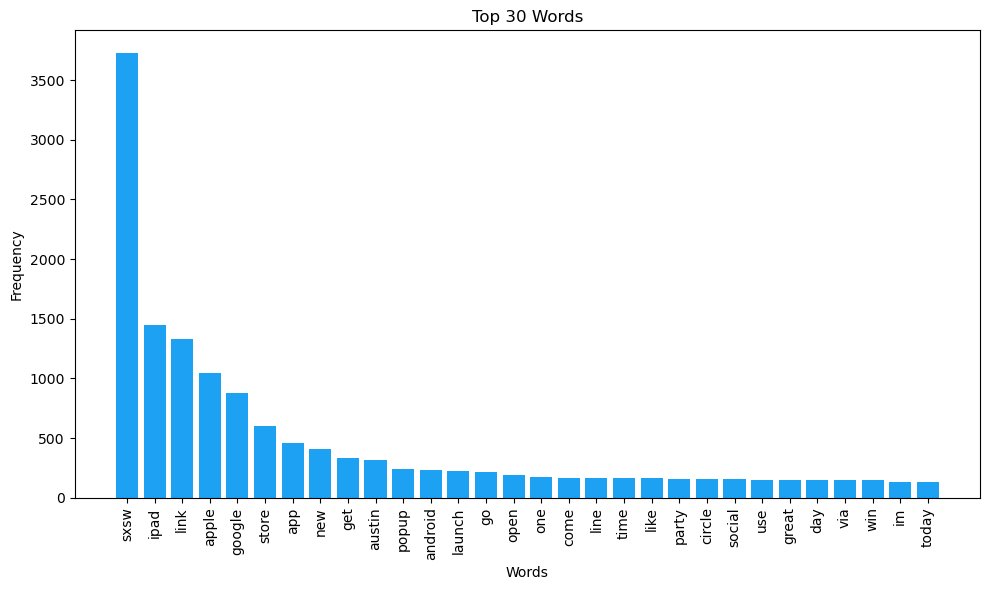

In [35]:
import matplotlib.pyplot as plt

# Top 10 words and their frequencies
top_words = word_counts.most_common(30)
words, frequencies = zip(*top_words)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='#1DA1F2')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [37]:
# # Function to create DataFrame with token and occurrence count
# def create_occurrence_df(text_data):
#     tokens = text_data.split()
#     token_counts = pd.Series(tokens).value_counts().reset_index()
#     token_counts.columns = ['Token', 'Occurrence Count']
#     token_counts = token_counts.sort_values(by='Occurrence Count', ascending=False)
#     return token_counts

# # Convert positive_text and negative_text to DataFrames with occurrence count
# positive_occurrence_df = create_occurrence_df(positive_text)
# negative_occurrence_df = create_occurrence_df(negative_text)

# # Print the positive DataFrame with occurrence count
# print('Positive Emotion DataFrame:')
# print(positive_occurrence_df.head(50))
# print()

# # Print the negative DataFrame with occurrence count
# print('Negative Emotion DataFrame:')
# print(negative_occurrence_df.head(50))


AttributeError: 'Series' object has no attribute 'split'

In [32]:
# # Read the dataset
# df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

# # Remove tweets with unknown sentiment
# df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

# # Remove 'No emotion toward brand or product' category
# df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != 'No emotion toward brand or product']

# # Filter positive and negative sentiment categories
# positive_text = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['tweet_text']
# negative_text = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['tweet_text']

# # Convert positive_text and negative_text to DataFrames with occurrence count
# positive_occurrence_df

NameError: name 'positive_occurrence_df' is not defined

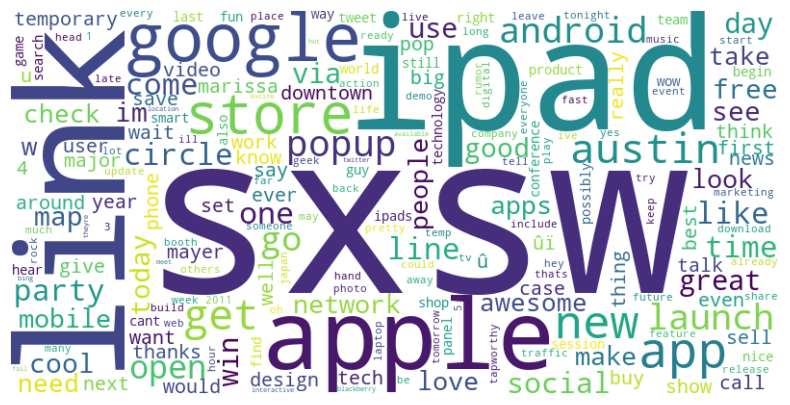

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Clean the text data
X_cleaned = clean_text(X, tokenizer, stopwords_list, remove_words)

# Tokenize the cleaned text
tokens = [token for tweet_tokens in X_cleaned for token in tokenizer.tokenize(tweet_tokens)]

# Remove the words specified for removal
tokens_filtered = [token for token in tokens if token not in remove_words]

# Create a frequency dictionary of the filtered words
word_freq = {}
for word in tokens_filtered:
    word_freq[word] = word_freq.get(word, 0) + 1

# Generate the word cloud based on the word frequency
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [39]:
# # Get the coefficients for the positive class
# coefficients = best_model_lr.named_steps['classifier'].coef_[0]

# # Get the top and bottom features
# sorted_indices = coefficients.argsort()
# top_features = [feature_names[idx] for idx in sorted_indices[:50]]
# bottom_features = [feature_names[idx] for idx in sorted_indices[-50:]]

# # Join the word lists for positive and negative emotions
# negative_text = ' '.join(top_features)
# positive_text = ' '.join(bottom_features)

# # Generate word clouds for positive and negative emotions
# generate_word_cloud(positive_text, 'Word Cloud - Positive Emotion')
# # generate_word_cloud(negative_text, 'Word Cloud - Negative Emotion')


NameError: name 'generate_word_cloud' is not defined

In [ ]:
# generate_word_cloud(negative_text, 'Word Cloud - Negative Emotion')

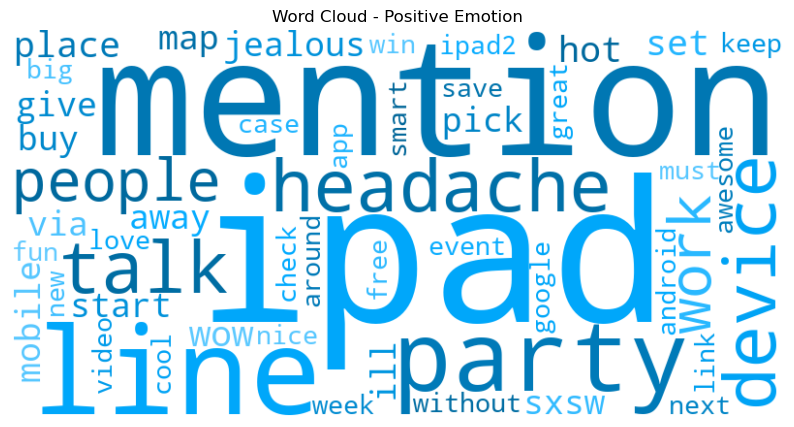

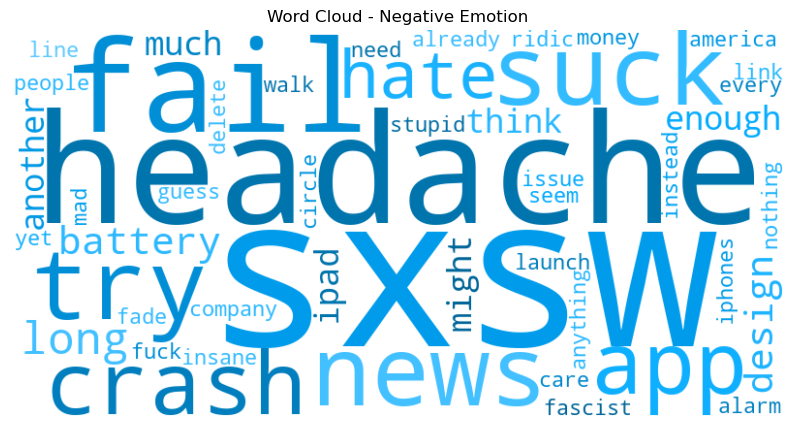

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Function to generate word cloud with custom color
def generate_word_cloud_with_color(text_data, title):
    # Define the color function
    def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(200, 100%%, %d%%)" % np.random.randint(30, 70)

    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=blue_color_func).generate(text_data)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for positive emotion with shades of blue
generate_word_cloud_with_color(positive_text, 'Word Cloud - Positive Emotion')
generate_word_cloud_with_color(negative_text, 'Word Cloud - Negative Emotion')


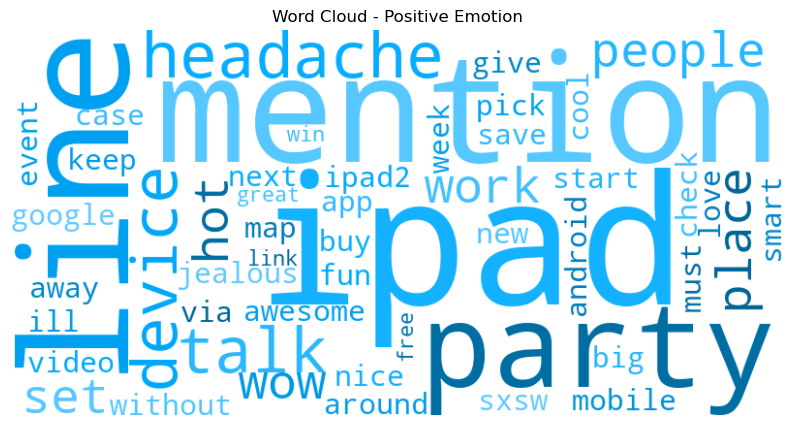

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Function to generate word cloud with custom color
def generate_word_cloud_with_color(text_data, title):
    # Define the color function for blue
    def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(200, 100%%, %d%%)" % np.random.randint(30, 70)

    # Define the color function for red
    def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(0, 100%%, %d%%)" % np.random.randint(30, 70)

    wordcloud = WordCloud(width=800, height=400, background_color='white')

    if "Positive" in title:
        wordcloud.generate_from_text(text_data)
        color_func = blue_color_func
    elif "Negative" in title:
        wordcloud.generate_from_text(text_data)
        color_func = red_color_func

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud.recolor(color_func=color_func), interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for positive emotion with shades of blue
generate_word_cloud_with_color(positive_text, 'Word Cloud - Positive Emotion')
# generate_word_cloud_with_color(negative_text, 'Word Cloud - Negative Emotion')


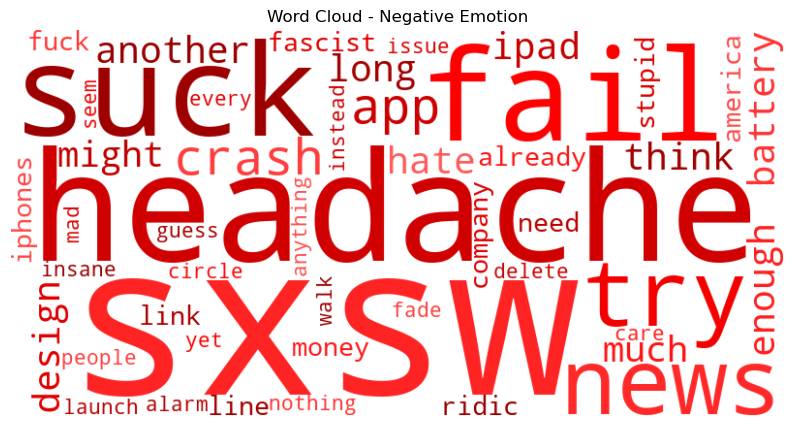

In [42]:
generate_word_cloud_with_color(negative_text, 'Word Cloud - Negative Emotion')

In [27]:
top_features

['fail',
 'suck',
 'hate',
 'long',
 'battery',
 'headache',
 'design headache',
 'news apps',
 'enough',
 'ipad news']

In [28]:
# generate_word_cloud(negative_text, 'Word Cloud - Negative Emotion')

In [29]:
# # Get the coefficients for the positive class
# coefficients = best_model_lr.named_steps['classifier'].coef_[0]

# # Get the top and bottom features
# sorted_indices = coefficients.argsort()
# top_features = [feature_names[idx] for idx in sorted_indices[:50] if feature_names[idx] not in remove_words]
# bottom_features = [feature_names[idx] for idx in sorted_indices[-50:] if feature_names[idx] not in remove_words]

# # Join the word lists for positive and negative emotions
# negative_text = ' '.join(top_features)
# positive_text = ' '.join(bottom_features)

# # Generate word clouds for positive and negative emotions
# generate_word_cloud(positive_text, 'Word Cloud - Positive Emotion')
# generate_word_cloud(negative_text, 'Word Cloud - Negative Emotion')


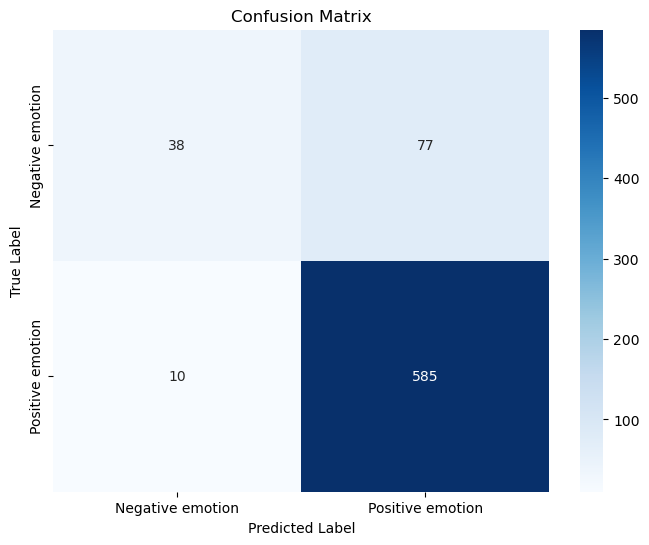

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels for the test set
y_pred = best_model_lr.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class labels
class_labels = best_model_lr.named_steps['classifier'].classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


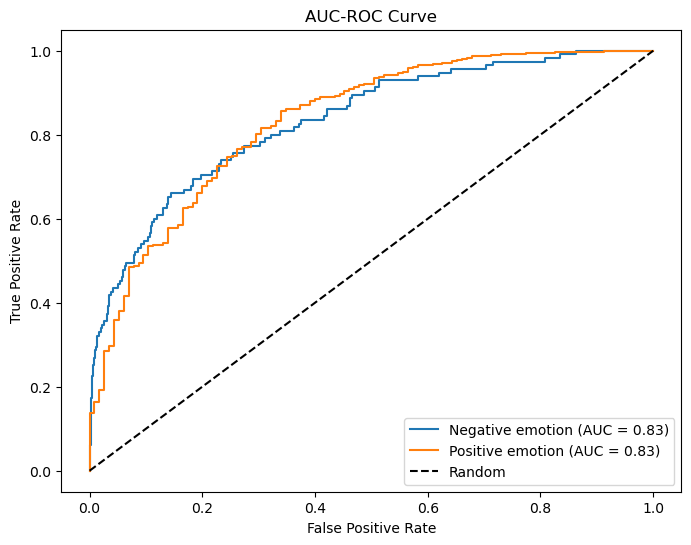

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
y_probs = best_model_lr.predict_proba(X_test)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(best_model_lr.named_steps['classifier'].classes_):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test, y_probs[:, i], pos_label=class_label)
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot the AUC-ROC curve for each class
plt.figure(figsize=(8, 6))
for class_label in best_model_lr.named_steps['classifier'].classes_:
    plt.plot(fpr[class_label], tpr[class_label], label=f'{class_label} (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()


![Image Description](Image/Twitter.png)

# If my team has gotten this far in this notebook..... Just know I am probably really tired lol 